# Current hierarichy performance

## Problem

We are launching a recommendation tool that identifies vendor cohorts and
suggests performance improvements based on peer comparisons within those
cohorts.  This ad hoc approach creates two risks for our MVP rollout: Weak
statistical foundation: We haven't validated whether our cohorts actually group
similar-performing vendors together Stakeholder confidence: Without a principled
justification for cohort boundaries, leadership are questioning recommendation
validity For more details, see [RFC - Reco cohort updating](https://docs.google.com/document/d/1N57UfysXpHLFVXMAi5htYw2L8hBySiKq9frPIBlvaPk/edit?tab=t.0#heading=h.wcy3kyozl6o0)

## Current cohort rule

Our current cohort rule uses a six-level nested hierarchy (Country → City → Area
→ Price → Cuisine → Grade) that was designed primarily for explainability to
account managers rather than analytical rigor. One shortcoming of the cohort
rule is that when there are an insufficient number of chains in a cohort, the
fallback is often to a broad “All” category. For example, 8% of vendors in the
UAE are in a category with the following dimension values

- Entity: tb_ae 
- City: All 
- Area: All 
- Priciness: All 
- Cuisine: All 
- Vendor Grade: All

Why so many? Our belief is that this is due to the fallback logic. A fallback
occurs when a proposed cohort has too few vendors for reliable comparison. In
the current rule, we switch from a granular cohort to the broadest relevant
cohort with the most chain ids.

## This iteration

- We provide a baseline estimate of the current cohort performance
    - Focus on TB_AE for speedier development
    - We drop around 1% of vendors due to complexity of implementing full fallback
    - Inference also focused on one month, not necessarily predictive
- We compare the baseline with some simple adjustments
    - Removing the fallback hierarchy allows us to group vendors with similar revenue
- We investigate the predictive performance of cohort dimensions
    - Vendor grade is important
    - We should to include Key Account sub categories

## Recommendations 

One more cycle of development. Gun to my head recommendation for today: 
- ‘Hierarchical, no cuisine’ provides a boost to performance measure similarity
over the current, while the largest, worst case cohorts are reduced to areas
within a city rather than the whole market as with the current.

In [1]:
from datetime import date
from highlight_text import fig_text
from functools import reduce, partial
from itertools import permutations
from scipy import stats
from scipy.stats import kruskal, f_oneway
from cohorts.calculating_cohort_statistics import get_groups, compare_outlier_methods

import os
import numpy as np
import pandas as pd
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt
import bigframes.pandas as bpd
import statsmodels.api as sm

import warnings
warnings.filterwarnings(action='once')

%load_ext google.cloud.bigquery
bpd.options.bigquery.project = "dhh-ncr-stg"

/Users/patrick.doupe/DH/ad_hoc/cohorts/.venv/lib/python3.13/site-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(


In [ ]:
TARGET_ENTITY = 'TB_AE'
CREATED_MONTH = '2025-07-01'

CURRENT_COHORT_PATH = 'dhh-ncr-stg.patrick_doupe.current_cohort_vendor_base'

## Current cohort rule

In [3]:
base_query = "SELECT * FROM `{path}` WHERE global_entity_id = '{target_entity}' AND DATE(created_month) = '{created_month}'"

df_current = pandas_gbq.read_gbq(base_query.format(path=CURRENT_COHORT_PATH, target_entity=TARGET_ENTITY, created_month=CREATED_MONTH))

/Users/patrick.doupe/DH/ad_hoc/cohorts/.venv/lib/python3.13/site-packages/pandas_gbq/gbq_connector.py:461: PendingDeprecationWarning: In a future major release, the default delimiter will be changed to a `/` in accordance with RFC9110.
  user_agent = create_user_agent(


Downloading: 100%|██████████|


In [4]:
df_current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27709 entries, 0 to 27708
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   global_entity_id  27709 non-null  object
 1   vendor_id         27709 non-null  object
 2   cohort_id         27709 non-null  Int64 
 3   created_month     27709 non-null  dbdate
 4   gmv               27709 non-null  object
 5   customers         27709 non-null  Int64 
 6   orders            27709 non-null  Int64 
dtypes: Int64(3), dbdate(1), object(3)
memory usage: 1.6+ MB


In [5]:
# convert gmv to float
df_current['gmv'] = pd.to_numeric(df_current['gmv'], errors='coerce')
assert df_current['gmv'].isna().sum() == 0, "There are NaNs in the GMV column"

Let's get some basic statistics and checks

In [6]:
df_current.describe()

,cohort_id,gmv,customers,orders
count,27709.0,27709.000000,27709.0,27709.0
mean,85003.19315,292.547740,12.61619,19.328052
std,74612.047604,719.282601,32.413023,47.303899
min,874.0,0.000000,0.0,0.0
25%,66257.0,0.000000,0.0,0.0
50%,81737.0,47.620000,2.0,4.0
75%,102214.0,253.250000,11.0,17.0
max,2002626.0,13986.880000,727.0,980.0


In [7]:
df_current[['gmv', 'customers', 'orders']].corr()

,gmv,customers,orders
gmv,1.000000,0.954608,0.966149
customers,0.954608,1.000000,0.989139
orders,0.966149,0.989139,1.000000


The three outcome columns are all highly correlated, let's proceed with GMV but armed with knowledge that if we match for GMV we match for orders and customers

In [8]:
n_vendors = df_current.vendor_id.nunique()
n_rows = df_current.shape[0]

assert n_vendors == n_rows, f"The numbers of rows {n_rows} differs from the number of vendors {n_vendors}"

n_cohorts = df_current.cohort_id.nunique()
n_cohorts_lt5 = (df_current.groupby("cohort_id")['vendor_id'].nunique() < 5).sum() 
n_cohorts_eq1 = (df_current.groupby("cohort_id")['vendor_id'].nunique() ==1).sum() 

print(f"The number of cohorts is {n_cohorts}")
print(f"The number of cohorts with less than five vendors is is {n_cohorts_lt5}")
print(f"The number of cohorts with one vendor is {n_cohorts_eq1}")

The number of cohorts is 2684
The number of cohorts with less than five vendors is is 0
The number of cohorts with one vendor is 0


In [9]:
# what are the biggest cohorts? 
df_current.groupby('cohort_id')['vendor_id'].nunique().sort_values(ascending=False).head()

cohort_id
70778    2422
82329     122
26704      76
72173      70
79490      61
Name: vendor_id, dtype: int64

That large cohort is large

In [10]:
df_current

,global_entity_id,vendor_id,cohort_id,created_month,gmv,customers,orders
0,TB_AE,23897,874,2025-07-01,444.77,33,46
1,TB_AE,736377,4228,2025-07-01,587.85,29,52
2,TB_AE,750314,5843,2025-07-01,1190.04,46,84
3,TB_AE,709585,8875,2025-07-01,789.36,34,54
4,TB_AE,733844,10139,2025-07-01,2536.65,94,129
...,...,...,...,...,...,...,...
27704,TB_AE,645429,82221,2025-07-01,610.49,19,29
27705,TB_AE,41859,82357,2025-07-01,672.58,20,29
27706,TB_AE,729971,90434,2025-07-01,656.16,27,29
27707,TB_AE,734608,96920,2025-07-01,408.48,15,29


Let's get the multiple that defines the top 5% of the distribution

In [11]:
multiple_of_mean_top_five_pc = df_current.gmv.quantile(q=0.95) / df_current.gmv.mean()
print(f"The 95th quantile of vendor revenue is {round(multiple_of_mean_top_five_pc, 1)} times the mean")

The 95th quantile of vendor revenue is 4.8 times the mean


Let's look at the distribution of GMV

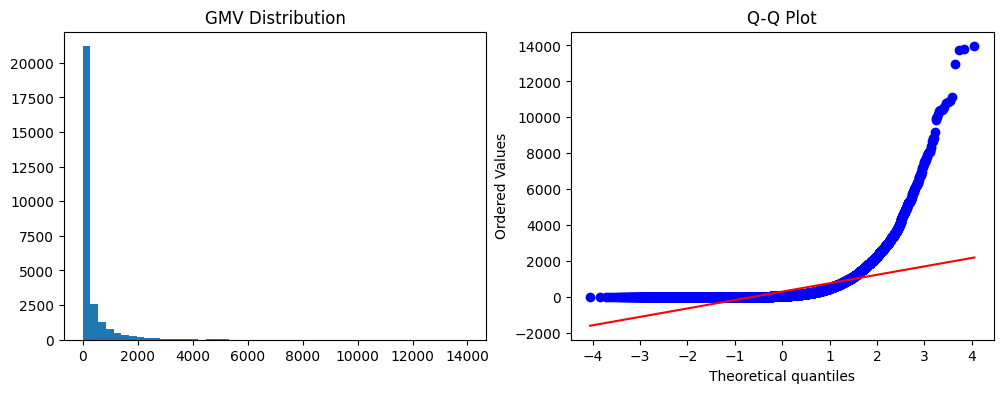

In [12]:
plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(df_current['gmv'], bins=50)
plt.title(f'GMV Distribution')

# Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df_current['gmv'], dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.show()

Yep, that's (probably) a power law. Not Gaußian in any case

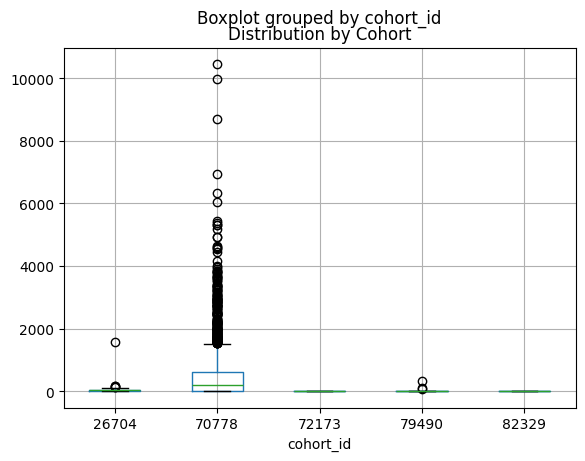

In [13]:
# Box plot by cohort (sample a few cohorts)
sample_cohorts = df_current['cohort_id'].value_counts().head(5).index
df_current[df_current['cohort_id'].isin(sample_cohorts)].boxplot(column='gmv', by='cohort_id')
plt.title('Distribution by Cohort')
plt.show()

Outliers are prevalent in cohorts for sure. Especially in cohort 70778.

Does taking the log solve things?

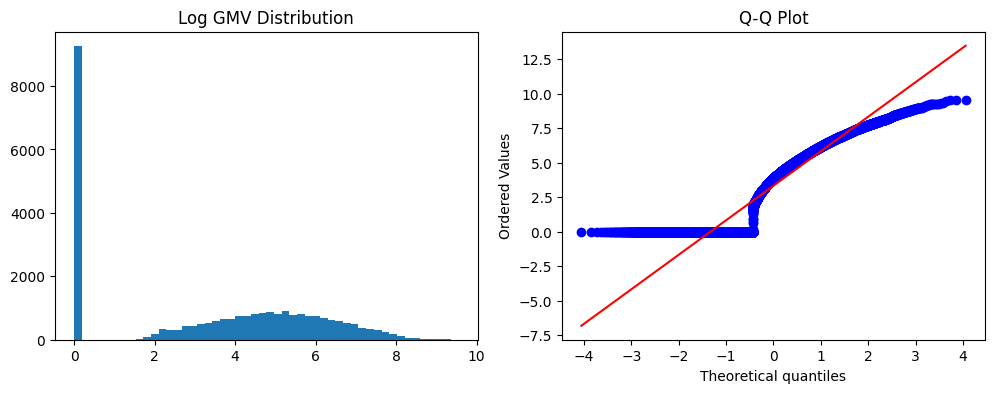

In [14]:
df_current['log_gmv'] = [np.log(1 + r) for r in df_current.gmv.values]

plt.figure(figsize=(12, 4))
# Histogram
plt.subplot(1, 2, 1)
plt.hist(df_current['log_gmv'], bins=50)
plt.title(f'Log GMV Distribution')
# Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df_current['log_gmv'], dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.show()

Not really

Let's get some basic statistics

In [15]:
cohort_groups_current = get_groups(df_current, performance_col='gmv', cohort_col='cohort_id')
f_stat, _ = f_oneway(*cohort_groups_current)
h_stat, _ = kruskal(*cohort_groups_current)

print(f"The f-stat for the current grouping is {f_stat:.2f}")
print(f"The H-stat for the current grouping is {h_stat:.2f}")

The f-stat for the current grouping is 11.28
The H-stat for the current grouping is 13624.55


In [18]:
outlier_comparison = compare_outlier_methods(df_current, 'gmv', 'cohort_id')

# Calculate summary statistics
share_cohorts_with_outlier_IQR = np.mean([min(1, x) for x in outlier_comparison.iqr_outliers])
share_cohorts_with_outlier_5x = np.mean([min(1, x) for x in outlier_comparison.mean_5x_outliers])

iqr_total_outliers = outlier_comparison['iqr_outliers'].sum()
mean_5x_total_outliers = outlier_comparison['mean_5x_outliers'].sum()
overlap_total_vendors = outlier_comparison['overlap_iqr_mean'].sum()

In [19]:
print("--- Outlier Analysis Summary ---")
print(f"Share of cohorts with IQR outliers: {share_cohorts_with_outlier_IQR:.3f}")
print(f"Share of cohorts with 5x Mean outliers: {share_cohorts_with_outlier_5x:.3f}")
print(f"Total IQR outliers across all cohorts: {iqr_total_outliers}")
print(f"Total 5x Mean outliers across all cohorts: {mean_5x_total_outliers}")
print(f"Total vendors with overlap in IQR and 5x Mean outliers: {overlap_total_vendors}")
print(f"H-statistic: {h_stat:.3f}")
print(f"F-statistic: {f_stat:.3f} (Note: F-stat typically from ANOVA, ensure source is correct)")

--- Outlier Analysis Summary ---
Share of cohorts with IQR outliers: 0.286
Share of cohorts with 5x Mean outliers: 0.149
Total IQR outliers across all cohorts: 1053
Total 5x Mean outliers across all cohorts: 544
Total vendors with overlap in IQR and 5x Mean outliers: 522
H-statistic: 13624.550
F-statistic: 11.276 (Note: F-stat typically from ANOVA, ensure source is correct)
